# Classification

## Acknowledgment 

Some of the content here is based on [Computational and Inferential Thinking: The Foundations of Data Science](https://inferentialthinking.com/chapters/intro.html), by A. Adhikari, J. DeNero, D. Wagner.

On the other hand, this text uses its own module `datascience` for data frame manipulations, while we will use pandas, which is the most commonly used library for data frames in Python.

## Importing Modules

Let's start by importing the necessary modules:

In [1]:
import numpy as np

import pandas as pd
# pd.options.future.infer_string = True
# pd.options.mode.copy_on_write = True

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)  # default figure size
plt.style.use("ggplot")  # style sheet

from tqdm.notebook import tqdm

## Introduction

Sometimes we want to use data to make predictions.  Here we will discuss a method of prediction for two possible outcomes, instead of a numerical value.  

This sort of prediction is referred to as *classification*.

Here are some examples:

* Does a person have a particular disease or not?
* Is a bank note a counterfeit or not?
* Does a picture show a cat or not?

In all these examples you want to use compare a new piece of data with previous instances, for which you know the answer, to decide on the classification of the new data.

For instance, in the first example, you can use data about exams or imaging from already (correctly) diagnosed patients, and compare the data from the new patient to this new data to make the decision.

Here we will deal only with *binary classification*, i.e., having only two classes for our classification.

In a classification task, each individual or situation where we'd like to make a prediction is called an *observation*.  We ordinarily have many observations.  

Each observation has multiple *attributes*, which are known (for example, white blood cells count or weight for a patient).  

Also, each observation has a *class*, which is the answer to the question we care about (for example, fraudulent or not, or picture of a cat or not).


## Nearest Neighbor Classifier

Let's look at an example.  The file [banknote.csv](banknote) (provided with this notebook) contains data collected by researchers, based on photographs of many individual banknotes: some counterfeit, some legitimate.  They computed a few numbers from each image, using techniques that we won't worry about here.  So, for each banknote, we know a few numbers that were computed from a photograph of it as well as its class: counterfeit, marked as Class 1, or not, marked as Class 0.

In [2]:
banknotes = pd.read_csv("banknote.csv")
banknotes

,WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


Let's add a color column, to help us draw scatter plots where we can distinguish the two classes by color.  We will use gold for counterfeit notes (Class 0) and dark blue for legitimate notes (Class 1):

In [3]:
color_table = pd.DataFrame(
    {"Class": np.array([1, 0]), "Color": np.array(["darkblue", "gold"])}
)

banknotes = pd.merge(banknotes, color_table, how="left")

banknotes

,WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class,Color
0,3.62160,8.66610,-2.8073,-0.44699,0,gold
1,4.54590,8.16740,-2.4586,-1.46210,0,gold
2,3.86600,-2.63830,1.9242,0.10645,0,gold
3,3.45660,9.52280,-4.0112,-3.59440,0,gold
4,0.32924,-4.45520,4.5718,-0.98880,0,gold
...,...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1,darkblue
1368,-1.38870,-4.87730,6.4774,0.34179,1,darkblue
1369,-3.75030,-13.45860,17.5932,-2.77710,1,darkblue
1370,-3.56370,-8.38270,12.3930,-1.28230,1,darkblue


Now let's write a function that allows us to pass a color column together with the scatter plot data, to produce colored scatter plots:

In [4]:
def scatter_group_color(df, x, y, color, **kwargs):
    """
    Uses a particular column with colors to split and color scatter
    graphs.

    INPUTS:
    df: data frame used for the scatter plot;
    x: label for the x-values;
    y: label for the y-values;
    color: label for the color column.

    OUTPUT:
    Scatter plot of df with colors according to color column.
    """
    fig, ax = plt.subplots()

    for c in df[color].unique():
        df_t = df.loc[df[color] == c]
        df_t.plot(x, y, kind="scatter", color=c, ax=ax, **kwargs)

Let's look at how the attributes `WaveltVar` and `WaveletCurt` relate to the classification:

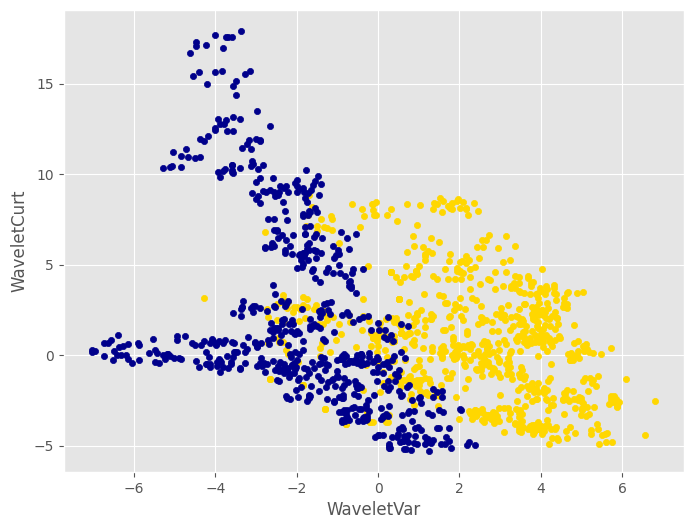

In [5]:
scatter_group_color(banknotes, "WaveletVar", "WaveletCurt", "Color")

As we can see, points to the right tend to be classified as 0 (legitimate), while points to the left tend to be classified as 1 (counterfeit), so you can see how a new bank note falling in either of those areas could be classified.  On the other hand, a new note that would fall in the middle region would be more difficult to classify.

But we are dropping some attributes!  For instance, adding the `WaveletSkew` attribute, we might be able to separate points that were very close before:

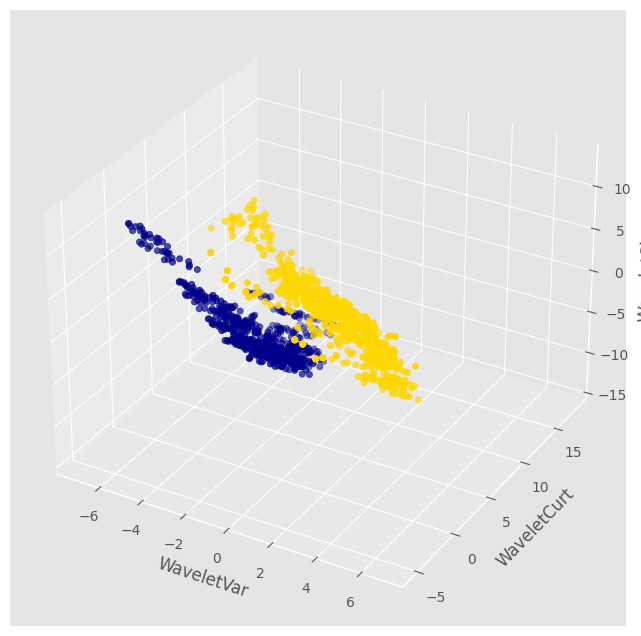

In [6]:
ax = plt.figure(figsize=(8, 8)).add_subplot(111, projection="3d")
ax.scatter(
    banknotes["WaveletVar"],
    banknotes["WaveletCurt"],
    banknotes["WaveletSkew"],
    c=banknotes["Color"],
)


ax.set_xlabel("WaveletVar")
ax.set_ylabel("WaveletCurt")
ax.set_zlabel("WaveletSkew");

Let's visualize how this with a specific example.  For instance, consider the new note:

In [7]:
new_note = np.array([0, 0, 0, 0])

With two attributes, it would be hard to make sure which classification we should give it:

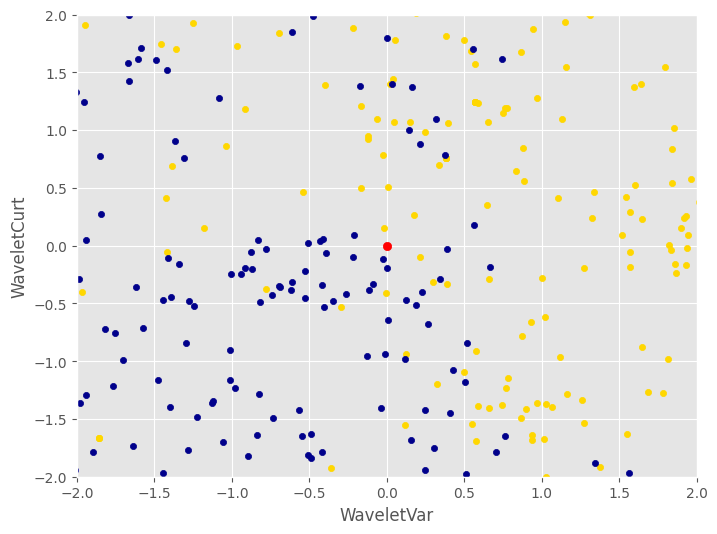

In [8]:
fig, ax = plt.subplots()

for c in banknotes["Color"].unique():
    df_t =banknotes.loc[banknotes["Color"] == c]
    df_t.plot("WaveletVar", "WaveletCurt", kind="scatter", color=c, ax=ax)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax.scatter(new_note[0], new_note[2], c="red");

But, adding a third attribute (`WaveletSkew`) we can add depth, and points that were basically on top of each other get separated:

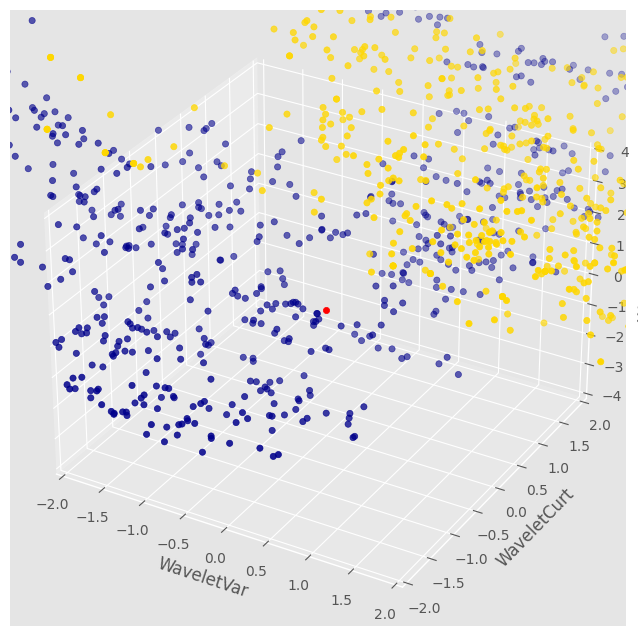

In [9]:
ax = plt.figure(figsize=(8, 8)).add_subplot(111, projection="3d")
ax.scatter(
    banknotes["WaveletVar"],
    banknotes["WaveletCurt"],
    banknotes["WaveletSkew"],
    c=banknotes["Color"],
    zorder=1
)

ax.scatter(new_note[0], new_note[2], new_note[1], c="red", zorder=5)

ax.set_xlim3d(-2, 2)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(-4, 4)

ax.set_xlabel("WaveletVar")
ax.set_ylabel("WaveletCurt")
ax.set_zlabel("WaveletSkew");

It is now clear that we should classify this note as *legitimate* (dark blue color.)

So, it is best to use as many attributes as we have!


### Classification

An initial idea for our classification then, is to just look at the *closest* point to our new one, and classify with the same class as this closest point.

Before we can write the code for these computations, we need to discuss how to compute distances.

## Measuring Distance

To measure the distance between two data points with two attributes (as in our example above), say $(x_0, y_0)$ and $(x_1, y_1)$, we simply compute

$$
\sqrt{(x_1-x_0)^2 + (y_1-y_0)^2}.
$$

This is simply the Pythagorean theorem: we have a right triangle with side lengths $|x_1-x_0|$ and $|y_1-y_0|$, and we want to find the length of the hypotenuse:

![distance](distance.png)

If we had two points in three dimensional space, e.g., if we had three attributes, say $(x_0, y_0, z_0)$ and $(x_1, y_1, z_1)$, then we can apply the Pythagorean theorem *twice* and obtain distance

$$
\sqrt{(x_1-x_0)^2 + (y_1-y_0)^2 + (z_1 - z_0)^2}.
$$

Although geometrically we can't quite visualize more dimensions, in practice we might have more than three attributes, and we still need to compute distances.  And we *can* do it! It follows a similar pattern: the distance between $(x_1, x_2, \ldots, x_n)$ and $(y_1, y_2, \ldots, y_n)$ is given by

$$
\sqrt{(x_1-y_1)^2 + (x_2-y_2)^2 + \cdots +  (x_n - y_n)^2}.
$$

**Bottom line:** To compute the distance between two points (in any number of dimensions):

* subtract their coordinates;
* square these differences;
* add all these squares;
* take the square root of this sum.

## Example

Let's now find the nearest point to a new given one.  We have four attributes, in this case.  Let's say our new data point is:

In [10]:
new_note = np.array([2, 5, -4, 0])

Let's compute distances from every bank note in our data frame to this new note:

In [11]:
# convert attributes to an array
attributes_array = banknotes.iloc[:, 0:4].to_numpy()

# compute the distance
distances = np.sqrt(
    np.sum(
        (attributes_array - new_note) ** 2,
        axis=1  # add rows!
    )
)

distances

array([ 4.20621078,  4.58559483,  9.84545886, ..., 29.1163946 ,
       21.91862585,  9.93726848])

Let's add distances to our data frame:

In [12]:
banknotes_with_dist = banknotes.assign(Distance=distances)

banknotes_with_dist

,WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class,Color,Distance
0,3.62160,8.66610,-2.8073,-0.44699,0,gold,4.206211
1,4.54590,8.16740,-2.4586,-1.46210,0,gold,4.585595
2,3.86600,-2.63830,1.9242,0.10645,0,gold,9.845459
3,3.45660,9.52280,-4.0112,-3.59440,0,gold,5.957956
4,0.32924,-4.45520,4.5718,-0.98880,0,gold,12.909133
...,...,...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1,darkblue,4.762746
1368,-1.38870,-4.87730,6.4774,0.34179,1,darkblue,14.796522
1369,-3.75030,-13.45860,17.5932,-2.77710,1,darkblue,29.116395
1370,-3.56370,-8.38270,12.3930,-1.28230,1,darkblue,21.918626


To find the closest one, we sort by distance and take the first one:

In [13]:
banknotes_with_dist.sort_values("Distance")

,WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class,Color,Distance
925,1.7425,3.6833,-4.0129,-1.72070,1,darkblue,2.181967
1352,1.4896,3.4288,-4.0309,-1.42590,1,darkblue,2.182504
1108,1.4501,3.6067,-4.0557,-1.59660,1,darkblue,2.189956
609,3.4092,5.4049,-2.5228,-0.89958,0,gold,2.267411
333,3.0009,5.8126,-2.2306,-0.66553,0,gold,2.288193
...,...,...,...,...,...,...,...
1369,-3.7503,-13.4586,17.5932,-2.77710,1,darkblue,29.116395
1125,-3.5985,-13.6593,17.6052,-2.49270,1,darkblue,29.197789
1064,-3.6961,-13.6779,17.5795,-2.61810,1,darkblue,29.220520
820,-4.0025,-13.4979,17.6772,-3.32020,1,darkblue,29.310869


As we can see, the closest point is classified as 1 (legitimate), so we would classify this new note as legitimate as well.

Also observe that we had some counterfeit notes not too far away!

This process of classification can also be automated, which we do below.

## $k$ Nearest Neighbors

If we get a new point that is closely surrounded by points of both classifications, simply choosing the classification of the nearest point is prone to incorrect classification.  Although this cannot be entirely avoid in a situation like this, an idea that could improve the results is to look at *a few* of the closest points, and classify the new one according to the *majority*.

For instance, in our previous example:

In [14]:
banknotes_with_dist.sort_values("Distance").head(10)

,WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class,Color,Distance
925,1.74250,3.6833,-4.0129,-1.72070,1,darkblue,2.181967
1352,1.48960,3.4288,-4.0309,-1.42590,1,darkblue,2.182504
1108,1.45010,3.6067,-4.0557,-1.59660,1,darkblue,2.189956
609,3.40920,5.4049,-2.5228,-0.89958,0,gold,2.267411
333,3.00090,5.8126,-2.2306,-0.66553,0,gold,2.288193
986,0.84546,3.4826,-3.6307,-1.39610,1,darkblue,2.391849
1345,2.22790,4.0951,-4.8037,-2.11120,1,darkblue,2.444153
313,2.12740,5.1939,-1.7971,-1.17630,0,gold,2.508043
1047,1.06370,3.6957,-4.1594,-1.93790,1,darkblue,2.521650
1169,0.98296,3.4226,-3.9692,-1.71160,1,darkblue,2.540292


Of the ten closest points to our new note, seven were legitimate notes (class 1), so we would classify it as legitimate as well.  Although in this case looking at more points does not change our classification, one can certainly see how it could happen.

**Note:** Usually we take an odd number of points, so that are no ties when we take the classification of the majority.

Let's now work on the implementation.

## Implementation

### Distances

As in our concrete example above, the first step is to create a data frame with all distances, sorted.

In [15]:
def df_with_dists(df, attributes, new_point):
    """
    Given a data frame and a list of the attributes labels, adds a column with 
    distances between the rows of df and the new_point and sort it by these
    distances.

    INPUTS:
    df: data frame to add distances and sort;
    attributes: list with labels for attributes;
    new_point: point to which we compute distances.

    OUTPUT:
    df with column of distances to new_point, sorted by distance.
    """
    # convert attributes to an array
    attributes_array = df[attributes].to_numpy()

    # compute the distance
    distances = np.sqrt(
        np.sum(
            (attributes_array - new_point) ** 2,
            axis=1  # add rows!
        )
    )

    return df.assign(Distance=distances).sort_values("Distance")

Let's test it with the previous example:

In [16]:
note_attr = ["WaveletVar", "WaveletSkew", "WaveletCurt", "Entropy"]
df_with_dists(banknotes, note_attr, new_note)

,WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class,Color,Distance
925,1.7425,3.6833,-4.0129,-1.72070,1,darkblue,2.181967
1352,1.4896,3.4288,-4.0309,-1.42590,1,darkblue,2.182504
1108,1.4501,3.6067,-4.0557,-1.59660,1,darkblue,2.189956
609,3.4092,5.4049,-2.5228,-0.89958,0,gold,2.267411
333,3.0009,5.8126,-2.2306,-0.66553,0,gold,2.288193
...,...,...,...,...,...,...,...
1369,-3.7503,-13.4586,17.5932,-2.77710,1,darkblue,29.116395
1125,-3.5985,-13.6593,17.6052,-2.49270,1,darkblue,29.197789
1064,-3.6961,-13.6779,17.5795,-2.61810,1,darkblue,29.220520
820,-4.0025,-13.4979,17.6772,-3.32020,1,darkblue,29.310869


### Majority Vote

Let's now write a function that takes a *series* (column of the data frame) of classifications, and returns the majority.

If we are dealing with only 0 and 1 in the classification, we can simply round the average the classifications to the nearest integer.  But let's make the code more robust here: it will really return the most common value.  (The classifications can be any objects, and there can even be more than one class.)

In [17]:
def majority_class(classifications, k):
    """
    Returns the most frequent value of the first k entries of classifications.

    INPUTS:
    classifications: series containing the classifications;
    k: number of nearest neighbors to use in majority classification.

    OUTPUT:
    Most occurred class among the first k in classifications.
    """
    return classifications.head(k).value_counts().index[0]

Now, we can combine the last two to make a single function that does the whole job:

In [18]:
def k_nearest_neighbors(df, attributes, new_point, k, class_label="Class"):
    """
    Classify new_point using the k nearest points.

    INPUTS:
    df: data frame used for classification;
    attributes: list of labels for the attribute columns;
    new_point: new point to be classified;
    k: number of neared neighbors;
    class_label: label for classification column.

    OUTPUT:
    Classification of new_point using k nearest neighbors.
    """
    classifications = df_with_dists(df, attributes, new_point)[class_label]
    return majority_class(classifications, k)

Using the same new note:

In [19]:
k_nearest_neighbors(banknotes, note_attr, new_note, 5)

1

## Testing the Classifier

Now, we need to test our classifier.  With this method, it does not help to reclassify the points we used in our classifier, since each point will be nearest to itself.  The standard practice in this situation is to split the data frame into a two *disjoint* subsets:

* *training set*: a subset for which we use the $k$ nearest neighbors method;
* *testing set*: a set we classify with our classifier, and verify the accuracy.

These two sets should be split randomly, with some given proportions.

Let's write a function for the splitting:

In [20]:
def split_df(df, first_prop):
    """
    Splits df randomly in two: one with proportion first_prop, and
    the other containing the rest.

    INPUTS:
    df: data frame to split;
    firt_prop: proportion of the original data frame to use for the first output.

    OUTPUT:
    Two random subsets of df, with first being of first_prop proportion.
    """

    df1 = df.sample(frac=first_prop)

    df2 = df.drop(df1.index)

    return df1.reset_index(drop=True), df2.reset_index(drop=True)

Let's split in 60/40 between training and testing:

In [21]:
training_df, testing_df = split_df(banknotes, 0.6)

In [22]:
len(training_df)

823

In [23]:
len(testing_df)

549

Now, we classify each entry of the testing data frame.  Let's write a function to help:

In [24]:
k = 5

# classify all rows
classifications = testing_df[note_attr].apply(
    lambda row: k_nearest_neighbors(training_df, note_attr, row.to_numpy(), k), axis=1
)

# add classifications as new column
testing_df_results = testing_df.assign(Result=classifications)

testing_df_results

,WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class,Color,Result
0,4.54590,8.1674,-2.45860,-1.46210,0,gold,0
1,3.45660,9.5228,-4.01120,-3.59440,0,gold,0
2,0.32924,-4.4552,4.57180,-0.98880,0,gold,0
3,4.36840,9.6718,-3.96060,-3.16250,0,gold,0
4,1.53560,9.1772,-2.27180,-0.73535,0,gold,0
...,...,...,...,...,...,...,...
544,-4.07860,2.9239,0.87026,-0.65389,1,darkblue,1
545,-0.24745,1.9368,-2.46970,-0.80518,1,darkblue,1
546,-2.41000,3.7433,-0.40215,-1.29530,1,darkblue,1
547,-1.38870,-4.8773,6.47740,0.34179,1,darkblue,1


Let's see the proportion of *correctly* classified notes:

In [25]:
np.count_nonzero(testing_df_results["Result"] == testing_df_results["Class"]) / len(
    testing_df_results
)

1.0

We obtained 100% accuracy!

Let's put this testing into a function as well:

In [26]:
def test_results_accuracy(training_df, testing_df, attributes, k):
    """
    Given training and testing data frames, classifiy the testing data frame using
    k nearest neighbors and returns the proportion of correct classifications.

    INPUTS:
    training_df: training data frame;
    testing_df: testing data frame;
    attributes: list of attribute column labels;
    k: number of nearest neighbors.

    OUTPUT:
    Proportion of correctly classified rows of testing_df.
    """
    classifications = testing_df[attributes].apply(
        lambda row: k_nearest_neighbors(training_df, attributes, row.to_numpy(), k),
        axis=1,
    )

    testing_df_results = testing_df.assign(Result=classifications)

    return np.count_nonzero(
        testing_df_results["Result"] == testing_df_results["Class"]
    ) / len(testing_df_results)

In [27]:
test_results_accuracy(training_df, testing_df, note_attr, 5)

1.0

### Speed vs Accuracy

As the example illustrates, this $k$ nearest neighbors method can be extremely accurate!

On the other hand, the classification in (relatively) quite slow.  For every new data point, we need to calculate its distance to the whole training data frame (which can be large), sort, and select the majority.

With modern computers (and not so large training sets), the computation time can be more than tolerable, though.

## Example: Detecting Brest Cancer

This example (from [Computational and Inferential Thinking: The Foundations of Data Science](https://inferentialthinking.com/chapters/intro.html), by A. Adhikari, J. DeNero, D. Wagner) is based on Brittany Wenger's [science fair project](https://sites.google.com/a/googlesciencefair.com/science-fair-2012-project-64a91af142a459cfb486ed5cb05f803b2eb41354-1333130785-87/home) of building a classification algorithm to diagnose breast cancer.  She won grand prize for building an algorithm whose accuracy was almost 99%.

Here we will use $k$ nearest neighbors.

Exams give us data to try to classify tumors as benign (class 0) or malignant (class 1).  The data is in the file [breast-cancer.csv](breas-cancer.csv) provided with this notebook.

In [28]:
patients = pd.read_csv("breast-cancer.csv").drop(columns="ID")
patients

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
678,3,1,1,1,3,2,1,1,1,0
679,2,1,1,1,2,1,1,1,1,0
680,5,10,10,3,7,3,8,10,2,1
681,4,8,6,4,3,4,10,6,1,1


First, we split the data frame into training and testing.  Let's use 60/40 again:

In [29]:
training_df, testing_df = split_df(patients, 0.5)

Now, let's test how well it did:

In [30]:
patients_attr = list(patients.columns[:-1])

test_results_accuracy(training_df, testing_df, patients_attr, 5)

0.9736070381231672

Not bad!

## Comments, Suggestions, Corrections

Please send your comments, suggestions, and corrections to lfinotti@utk.edu.